# AI Concierge Feedback Loop — Weekly Property Cohorts

**Goal**  
Turn last week’s post-stay feedback into next week’s operational plays, estimate impact, and rank what to pilot.

**Loop**  
1) Ingest feedback  
2) Theme issues  
3) Generate fixes (LLM)  
4) Simulate next-cohort reaction  
5) Score sentiment lift + ops feasibility  
6) Prioritize for pilots; measure the following week

**What we’ll run now**  
- Generate a synthetic dataset (50k rows)  
- Sample complaints for the agent (to keep cost/speed tight)  
- Run Theme → Suggest → Simulate (OpenAI)  
- Score lift + feasibility and produce a ranked list




In [1]:
# -------------------------------------------------------------
# Install all required libraries
# -------------------------------------------------------------
# openai           → Official OpenAI Python SDK
# python-dotenv    → Loads environment variables from a .env file
# langchain        → Prompt orchestration & structured output parsing
# langchain-openai → LangChain adapter for OpenAI models
# pandas           → DataFrame handling
# scikit-learn     → Cosine similarity for theme mapping & other ML utilities
# textblob         → Sentiment scoring
# nltk             → Tokenization for TextBlob
%pip install --quiet --upgrade openai python-dotenv langchain langchain-openai pandas scikit-learn textblob nltk


Note: you may need to restart the kernel to use updated packages.


In [2]:
# ------------------------------------------------------------------------
# Load OpenAI API key from a plain text file into the environment
# ------------------------------------------------------------------------

import os  # Standard Python library for environment variables & file handling

# 1) Read the key from the text file
#    Make sure OPENAI_API_KEY.txt contains only the key, no spaces or quotes.
with open("OPENAI_API_KEY.txt", "r") as f:
    api_key = f.read().strip()  # .strip() removes newline characters

# 2) Store it in the environment for the current Python process
os.environ["OPENAI_API_KEY"] = api_key

# 3) Quick sanity check (print only part of the key for security)
if api_key:
    print(f"OpenAI API key loaded from file: {api_key[:5]}...{api_key[-5:]}")
else:
    print(" API key not found in OPENAI_API_KEY.txt. Please check the file content.")


OpenAI API key loaded from file: sk-pr...ap_MA


In [3]:

# Load environment variables from a .env file and verify OpenAI API key


from dotenv import load_dotenv  # Library to load variables from a .env file into the OS environment
import os                       # Standard library to access environment variables

# 1) Load variables from .env (if it exists in the current working directory)
#    This will populate os.environ with any KEY=VALUE pairs in the file.
load_dotenv()

# 2) Retrieve the OpenAI API key from the environment
#    NOTE: This will only work if:
#          - You previously stored your key in a .env file as OPENAI_API_KEY=sk-proj-...
#          - OR you set it earlier in this notebook using os.environ["OPENAI_API_KEY"] = ...
api_key = os.getenv("OPENAI_API_KEY")

# 3) Print the API key (only for testing — do NOT display full keys in production)
#    In real workflows, mask part of it for security:
#    print(f"{api_key[:5]}...{api_key[-5:]}")
#print(api_key)  # Should print your key in full here for confirmation


In [4]:

# Set up NLTK and TextBlob for sentiment analysis

import nltk  # Natural Language Toolkit — used for tokenization and lexicons

# 1) Download the 'punkt' tokenizer
#    - Required by TextBlob and other NLP tools to split text into sentences/words.
#    - It's lightweight and only needs to be downloaded once per environment.
nltk.download('punkt')

# 2) Download the 'vader_lexicon'
#    - VADER (Valence Aware Dictionary and sEntiment Reasoner) is a pre-built sentiment
#      lexicon tuned for social media and short text.
#    - We'll use it indirectly via TextBlob or could use it directly for polarity scoring.
nltk.download('vader_lexicon')

# 3) Import TextBlob
#    - TextBlob is a simple NLP library built on top of NLTK and Pattern.
#    - We'll use its .sentiment.polarity method to measure pre- and post-change sentiment
#      in guest feedback.
from textblob import TextBlob



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
# ------------------------------------------------------------------------
# Generate a synthetic guest feedback dataset (50,000 rows)
# ------------------------------------------------------------------------

import random, numpy as np, pandas as pd  # Libraries for randomness, numeric ops, and data handling
from pathlib import Path                  # Easier path handling across OSes

# ---- Config
N_ROWS = 50_000  # Number of synthetic feedback records to generate
OUT_DIR = Path("data")  # Output folder for saving the dataset
OUT_DIR.mkdir(parents=True, exist_ok=True)  # Create folder if it doesn't exist
OUT_PATH = OUT_DIR / "guest_feedback_big.csv"  # Full path to output CSV file

SEED = 123
random.seed(SEED); np.random.seed(SEED)  # For reproducibility of results

# ---- Pools: predefined values to randomly choose from
# Hotels with name, city, state, and property type
PROPERTIES = [
    ("Marriott Tampa Waterside","Tampa","FL","Resort"),
    ("JW Marriott Orlando","Orlando","FL","Convention"),
    ("Courtyard Miami Beach","Miami","FL","Urban"),
    ("Ritz-Carlton Sarasota","Sarasota","FL","Resort"),
    ("AC Hotel Tampa Downtown","Tampa","FL","Urban"),
    ("Moxy Miami South Beach","Miami","FL","Lifestyle"),
    ("Marriott Marquis Houston","Houston","TX","Convention"),
    ("Westin Bonaventure Los Angeles","Los Angeles","CA","Urban"),
    ("W New York Times Square","New York","NY","Urban"),
    ("Sheraton Boston","Boston","MA","Convention"),
]
CHANNELS = ["in-stay chat","post-stay email","Bonvoy App","TripAdvisor","SMS","Front desk survey"]
PURPOSES = ["business","leisure","family","conference"]
ROOM_TYPES = ["standard","deluxe","suite"]
LOYALTY = ["Non-member","Member","Silver","Gold","Platinum","Titanium","Ambassador"]

# ---- Templates for complaint generation with placeholders
COMPLAINT_TEMPLATES = [
    "Check-in took {delay} minutes; line was too long.",
    "Requested {item} twice and still waiting.",
    "Gym opens too {time} for my schedule.",
    "Breakfast line was {adj}; waited {delay} minutes.",
    "WiFi kept {issue} during meetings.",
    "Room was {adj2} when I arrived.",
    "AC was {issue2}; room never cooled properly.",
    "Pool hours end too {time} for families.",
    "Parking fee felt {adj} given the stay.",
    "Housekeeping missed {item} restock.",
]
# Variables for complaint templates
VAR = {
    "delay": ["15","25","35","45","55","65","75"],
    "item": ["extra towels","toiletries","blanket","water","pillows"],
    "time": ["late","early"],
    "adj": ["insane","long","excessive","unexpected","ridiculous"],
    "adj2": ["messy","dusty","unclean","musty"],
    "issue": ["dropping","disconnecting","slow"],
    "issue2": ["noisy","weak","broken"],
}

# ---- Templates for praise comments
PRAISE_TEMPLATES = [
    "Staff were incredibly helpful and friendly.",
    "Room was spotless and the bed was comfortable.",
    "Great location and smooth check-in.",
    "Concierge solved my problem in minutes.",
    "Loved the breakfast selection and service.",
    "Lobby vibe and bar were fantastic.",
]

# ---- A small set of multilingual comments (for realism)
NON_EN = [
    ("es", "El registro fue rápido y el personal muy amable."),
    ("es", "La fila del desayuno fue larga."),
    ("fr", "La chambre était propre et confortable."),
    ("de", "Check-in hat zu lange gedauert."),
    ("hi", "स्टाफ़ बहुत मददगार था।"),
]

# ---- Helper function: fills a complaint template with random variable values
def fill_template(tpl: str) -> str:
    out = tpl
    for k, vals in VAR.items():
        tok = "{"+k+"}"
        if tok in out:
            out = out.replace(tok, random.choice(vals))
    return out

# ---- Helper function: randomly add typos to ~4% of texts
def add_typos(text: str, p: float = 0.04) -> str:
    if random.random() > p or len(text) < 6:
        return text
    i = random.randrange(1, len(text)-1)
    return text[:i] + text[i] + text[i] + text[i+1:]

# ---- Helper function: pick a random date in 2025 with weighted month probabilities
def pick_date_2025() -> str:
    m = random.choices(range(1,13), weights=[6,6,7,7,8,10,11,10,8,7,6,6])[0]
    d = random.randint(1,28)  # keep safe for all months
    return f"2025-{m:02d}-{d:02d}"

# ---- Main loop: generate N_ROWS feedback entries
rows = []
for i in range(1, N_ROWS+1):
    prop, city, state, ptype = random.choice(PROPERTIES)
    channel = random.choice(CHANNELS)
    purpose = random.choices(PURPOSES, weights=[0.45,0.35,0.15,0.05])[0]
    room = random.choices(ROOM_TYPES, weights=[0.6,0.3,0.1])[0]
    tier = random.choices(LOYALTY, weights=[0.25,0.25,0.2,0.15,0.1,0.04,0.01])[0]
    date = pick_date_2025()

    # 70% complaint, 30% praise
    if random.random() < 0.7:
        text = fill_template(random.choice(COMPLAINT_TEMPLATES))
        is_complaint = 1
    else:
        text = random.choice(PRAISE_TEMPLATES)
        is_complaint = 0

    # ~3% multilingual feedback
    if random.random() < 0.03:
        _, text = random.choice(NON_EN)

    # Random typos for realism
    text = add_typos(text, 0.04)

    # Extract wait time from comment text if present
    wait = next((int(tok) for tok in text.split() if tok.isdigit()), 0)

    # Random stay length, adults, and kids
    stay_len = random.choices([1,2,3,4,5,6,7], weights=[0.25,0.25,0.2,0.15,0.08,0.05,0.02])[0]
    adults = random.choice([1,1,2,2,2,3])
    kids = random.choices([0,0,0,1,2], weights=[0.6,0.25,0.1,0.03,0.02])[0]

    # Append row dict to our rows list
    rows.append({
        "feedback_id": i,
        "property": prop, "city": city, "state": state, "property_type": ptype,
        "channel": channel, "created_at": date, "comment_text": text,
        "stay_purpose": purpose, "room_type": room, "loyalty_tier": tier,
        "stay_length_nights": stay_len, "party_adults": adults, "party_kids": kids,
        "observed_wait_minutes": wait, "is_complaint": is_complaint
    })

# ---- Create DataFrame and save to CSV
df = pd.DataFrame(rows)
df.to_csv(OUT_PATH, index=False)

# ---- Confirmation
print(f"Generated {len(df):,} rows -> {OUT_PATH}")
df.head(8)


Generated 50,000 rows -> data/guest_feedback_big.csv


,feedback_id,property,city,state,property_type,channel,created_at,comment_text,stay_purpose,room_type,loyalty_tier,stay_length_nights,party_adults,party_kids,observed_wait_minutes,is_complaint
0,1,Marriott Tampa Waterside,Tampa,FL,Resort,Bonvoy App,2025-11-02,Parking fee felt excessive given the stay.,business,standard,Non-member,1,2,0,0,1
1,2,Ritz-Carlton Sarasota,Sarasota,FL,Resort,post-stay email,2025-07-03,Pool hours end too late for families.,business,standard,Non-member,1,1,0,0,1
2,3,Marriott Marquis Houston,Houston,TX,Convention,SMS,2025-05-17,Room was spotless and the bed was comfortable.,leisure,standard,Non-member,3,2,0,0,0
3,4,W New York Times Square,New York,NY,Urban,TripAdvisor,2025-11-16,AC was weak; room never cooled properly.,leisure,deluxe,Silver,3,3,0,0,1
4,5,Westin Bonaventure Los Angeles,Los Angeles,CA,Urban,Front desk survey,2025-11-24,स्टाफ़ बहुत मददगार था।,business,standard,Silver,3,1,0,0,1
5,6,Ritz-Carlton Sarasota,Sarasota,FL,Resort,TripAdvisor,2025-08-16,Lobby vibe and bar were fantastic.,leisure,deluxe,Platinum,7,1,2,0,0
6,7,Westin Bonaventure Los Angeles,Los Angeles,CA,Urban,TripAdvisor,2025-03-09,Lobby vibe and bar were fantastic.,leisure,standard,Non-member,2,1,0,0,0
7,8,W New York Times Square,New York,NY,Urban,Bonvoy App,2025-10-13,AC was noisy; room never cooled properly.,leisure,standard,Platinum,2,2,0,0,1


In [6]:

# Step: Load the generated guest feedback dataset and inspect it


# 1) Read the CSV we just generated into a pandas DataFrame.
#    - "data/guest_feedback_big.csv" is the file path we saved earlier.
#    - pandas automatically parses it into a tabular structure with columns & rows.
df = pd.read_csv("data/guest_feedback_big.csv")

# 2) Print the shape (rows, columns) of the dataset.
#    - Helps us confirm the size matches our expectation (should be 50,000 rows × number of fields).
print(df.shape)  # e.g., (50000, 15)

# 3) Show 5 random rows from the dataset.
#    - Using a fixed random_state so the same sample is shown each time (for reproducibility).
df.sample(5, random_state=42)



(50000, 16)


,feedback_id,property,city,state,property_type,channel,created_at,comment_text,stay_purpose,room_type,loyalty_tier,stay_length_nights,party_adults,party_kids,observed_wait_minutes,is_complaint
33553,33554,W New York Times Square,New York,NY,Urban,Front desk survey,2025-08-12,Staff were incredibly helpful and friendly.,business,standard,Non-member,7,2,0,0,0
9427,9428,Westin Bonaventure Los Angeles,Los Angeles,CA,Urban,SMS,2025-07-10,Requeested extra towels twice and still waiting.,business,deluxe,Gold,6,2,0,0,1
199,200,AC Hotel Tampa Downtown,Tampa,FL,Urban,post-stay email,2025-02-07,Room was musty when I arrived.,business,deluxe,Silver,2,3,0,0,1
12447,12448,Moxy Miami South Beach,Miami,FL,Lifestyle,Front desk survey,2025-01-27,Breakfast line was unexpected; waited 25 minutes.,leisure,deluxe,Platinum,3,1,0,25,1
39489,39490,AC Hotel Tampa Downtown,Tampa,FL,Urban,SMS,2025-06-03,Requested water twice and still waiting.,business,standard,Silver,7,1,0,0,1


In [7]:
# Step: Set up LangChain agents for theme detection, suggestion generation,
# and simulated post-fix guest feedback using OpenAI's Chat models.


from langchain_openai import ChatOpenAI                     # Wrapper for OpenAI chat models
from langchain.prompts import ChatPromptTemplate            # For creating reusable prompt templates
from langchain.output_parsers import StructuredOutputParser, ResponseSchema  # For forcing structured JSON outputs




In [8]:
# 1) Initialize the LLM (Language Model)
# - Using "gpt-4o-mini" here because it's cost-effective and fast for prototyping.
# - You can switch to "gpt-4o" for higher accuracy, but at a higher cost.
# - temperature=0.2 keeps responses more deterministic (less randomness).
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)

In [9]:
# 2) Define JSON response schemas for structured outputs


# a) Parser for THEME detection
#    "theme" → short, operational category (e.g., "WiFi reliability").
#    "reason" → short justification for why this category fits.
theme_parser = StructuredOutputParser.from_response_schemas([
    ResponseSchema(name="theme", description="Short theme like 'Check-in lines' or 'WiFi reliability'"),
    ResponseSchema(name="reason", description="Why this theme fits"),
])

# b) Parser for SUGGESTION generation
#    Captures the fix, rationale, team ownership, implementation effort, and expected outcome.
sugg_parser = StructuredOutputParser.from_response_schemas([
    ResponseSchema(name="suggestion", description="Concrete fix testable in 2–4 weeks"),
    ResponseSchema(name="rationale", description="Why this helps"),
    ResponseSchema(name="owner_team", description="Front Desk/Housekeeping/IT/F&B/Engineering/Revenue Ops/etc."),
    ResponseSchema(name="effort", description="low|medium|high"),
    ResponseSchema(name="expected_outcome", description="Operational outcome in business terms"),
])

# c) Parser for SIMULATION
#    Generates a realistic, short follow-up comment from a guest after the fix has been implemented.
sim_parser = StructuredOutputParser.from_response_schemas([
    ResponseSchema(name="simulated_followup", description="1–3 sentence guest comment AFTER the fix, natural and realistic"),
])

In [10]:
# 3) Create reusable prompt templates for each task

# THEME detection prompt
theme_prompt = ChatPromptTemplate.from_messages([
    ("system", "You label hotel guest feedback into a concise operational theme."),
    ("human", """Comment: {comment}
Return JSON only:
{format_instructions}""")
])

# SUGGESTION generation prompt
sugg_prompt = ChatPromptTemplate.from_messages([
    ("system", "You propose operational fixes for hotels. Be specific and testable."),
    ("human", """Theme: {theme}
Comment: {comment}
Constraints: reasonable cost; testable in 2–4 weeks.
Return JSON only:
{format_instructions}""")
])

# SIMULATION prompt
sim_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a realistic hotel guest writing a follow-up after the fix."),
    ("human", """Original comment: {comment}
Implemented change: {suggestion}
Return JSON only:
{format_instructions}""")
])


In [11]:
# 4) Define helper functions ("agents") to run each task


def theme_agent(comment: str):
    """
    Detects the operational theme from a guest comment.
    Returns a dict with:
        - theme: short category label
        - reason: why this category was chosen
    """
    msg = theme_prompt.format_messages(
        comment=comment,
        format_instructions=theme_parser.get_format_instructions()
    )
    return theme_parser.parse(llm.invoke(msg).content)

def suggestion_agent(theme: str, comment: str):
    """
    Suggests a fix for the given theme + comment.
    Returns a dict with:
        - suggestion, rationale, owner_team, effort, expected_outcome
    """
    msg = sugg_prompt.format_messages(
        theme=theme,
        comment=comment,
        format_instructions=sugg_parser.get_format_instructions()
    )
    return sugg_parser.parse(llm.invoke(msg).content)

def simulation_agent(comment: str, suggestion: str):
    """
    Simulates a follow-up guest comment after the suggested fix is implemented.
    Returns:
        - simulated_followup: realistic, short guest feedback
    """
    msg = sim_prompt.format_messages(
        comment=comment,
        suggestion=suggestion,
        format_instructions=sim_parser.get_format_instructions()
    )
    return sim_parser.parse(llm.invoke(msg).content)


In [12]:

# Step: Define helper functions for sentiment scoring and operational scoring


def polarity(s: str) -> float:
    """
    Calculates the sentiment polarity of a given string.
    - Uses TextBlob's sentiment analysis (range: -1 to 1).
        * -1.0 → very negative
        *  0.0 → neutral
        * +1.0 → very positive
    - Converts the input to string (in case it's None or another type).
    - Returns 0.0 if an error occurs (failsafe).
    
    Example:
        polarity("I loved my stay!")   -> 0.625 (positive)
        polarity("The room was dirty") -> -0.5   (negative)
    """
    try:
        return TextBlob(str(s)).sentiment.polarity
    except:
        return 0.0  # Safe fallback if TextBlob fails


def ops_score(expected_outcome: str, effort: str) -> float:
    """
    Produces a simple 'operational score' combining:
        - Potential business impact (from expected outcome description).
        - Implementation effort (low/medium/high).
    
    Logic:
        1) Look at the 'expected_outcome' string to detect high-value terms:
           If it contains terms like 'shorter', 'reduce', 'fewer', 'increase', or 'throughput',
           then base impact is set to 0.5 (higher priority).
           Otherwise, base impact is 0.2.
        
        2) Apply a penalty based on effort:
           - Low effort → 0.0 penalty  (keeps full impact)
           - Medium effort → 0.1 penalty
           - High effort → 0.25 penalty (more costly to implement)
        
        3) Add +0.1 as a bias towards implementing changes (encourages action).
        
        4) Clamp the score between 0.0 and 1.0 for consistency.
    
    Example:
        ops_score("Reduce breakfast wait times", "low")   -> ~0.6
        ops_score("Improve WiFi coverage", "high")        -> ~0.35
    """
    eo = (expected_outcome or "").lower()  # normalize text
    # Step 1: Assign base impact score
    base = 0.5 if any(k in eo for k in ["shorter", "reduce", "fewer", "increase", "throughput"]) else 0.2
    # Step 2: Penalty based on implementation effort
    penalty = {"low": 0.0, "medium": 0.1, "high": 0.25}.get((effort or "").lower(), 0.1)
    # Step 3 & 4: Apply penalty, add bias, clamp between 0 and 1
    return max(0.0, min(1.0, base - penalty + 0.1))


In [13]:

# Step: Select a sample of complaint feedback for AI agent processing


from tqdm import tqdm  # tqdm → progress bar library (we'll use it in later loops)

# 1) Filter only complaint rows from the dataset
#    'is_complaint' == 1 means this row is a guest complaint.
#    This reduces the dataset to only relevant rows for improvement suggestions.
complaints = df[df["is_complaint"] == 1].copy()

# 2) Randomly select a smaller subset for demonstration/testing.
#    Here we take 120 random complaint rows.
#    Fixing random_state=42 ensures reproducibility (same sample every run).
sample = complaints.sample(120, random_state=42).reset_index(drop=True)

# 3) Check how many rows we selected.
#    Should be exactly 120 unless dataset is smaller.
len(sample)



120

In [14]:

# Process hotel guest complaint feedback
# Features:
#   - Progress bar for visibility during processing
#   - Controlled vocabulary mapping for consistent theme names
#   - Retry logic for API calls to handle temporary failures
#   - Sentiment lift calculation before vs. after suggested fix


# Install tqdm quietly (progress bar library)
!pip -q install tqdm

# ===== 1. IMPORTS =====
import time                          # For delays between retries
import os                            # For environment variable access
import numpy as np                   # For numerical operations
import pandas as pd                  # For DataFrame handling
from tqdm import tqdm                 # For progress bar
from sklearn.metrics.pairwise import cosine_similarity  # For comparing embeddings
from openai import OpenAI             # OpenAI API client

# ===== 2. OPENAI CLIENT & MODEL =====
client = OpenAI()                     # Auto-reads OPENAI_API_KEY from .env file
EMBED_MODEL = "text-embedding-3-small" # Cheap & fast embedding model for similarity

# ===== 3. HELPER: truncate long text for progress bar display =====
def _truncate(s, n=40):
    """
    Shortens a string `s` to at most `n` characters.
    Adds "…" if truncated.
    Example: _truncate("This is long text", 10) -> "This is lo…"
    """
    return (s[:n] + "…") if s and len(s) > n else (s or "")

# ===== 4. HELPER: retry wrapper for API calls =====
def _retry(fn, *args, retries=3, backoff=1.6, **kwargs):
    """
    Runs the function `fn` with retries if it raises an exception.
    - retries: total attempts before giving up
    - backoff: multiplier for wait time between retries
      Example: backoff=1.6 -> delays: 1s, 1.6s, 2.56s
    """
    for i in range(retries):
        try:
            return fn(*args, **kwargs)   # Try calling the function
        except Exception:
            if i == retries - 1:         # If last attempt, re-raise error
                raise
            time.sleep(backoff ** i)     # Otherwise wait before retrying

# ===== 5. CONTROLLED VOCABULARY =====
# These are the only "approved" theme names for our output.
# Keeps things consistent even if the LLM invents variations like "Breakfast wait times" vs. "Breakfast service".
ALLOWED_THEMES = [
    "Breakfast service",
    "Check-in wait times",
    "Pool hours",
    "WiFi reliability",
    "Air conditioning issues",
    "Room cleanliness",
    "Housekeeping",
    "Parking fees",
    "Gym hours",
    "Room service delays",
    "Towel service",
    "Pillow requests",
    "Room amenities",
    "Staff assistance",
    "Toiletries availability"
]

# ===== 6. EMBEDDING CACHE FOR ALLOWED THEMES =====
_allowed_vecs = None  # Stores precomputed vectors for allowed themes

def _get_allowed_vecs():
    """
    Returns embeddings for all ALLOWED_THEMES.
    Computes once and caches in memory for speed.
    """
    global _allowed_vecs
    if _allowed_vecs is None:
        # Get embeddings from OpenAI for the list of allowed themes
        resp = _retry(client.embeddings.create, model=EMBED_MODEL, input=ALLOWED_THEMES)
        _allowed_vecs = np.array([d.embedding for d in resp.data])
    return _allowed_vecs

# ===== 7. THEME MAPPING CACHE =====
_theme_map_cache = {}  # Avoids re-embedding the same raw theme repeatedly

def map_theme_to_allowed(raw_theme: str) -> str:
    """
    Maps a raw theme from the LLM to the closest theme in ALLOWED_THEMES
    using cosine similarity between embeddings.
    """
    if not raw_theme:  # If empty, return a default category
        return "Uncategorized"

    key = raw_theme.strip().lower()  # Normalize string for cache lookup
    if key in _theme_map_cache:       # If seen before, return stored mapping
        return _theme_map_cache[key]

    # Embed the raw theme using OpenAI
    emb_resp = _retry(client.embeddings.create, model=EMBED_MODEL, input=[raw_theme])
    emb_vec = np.array(emb_resp.data[0].embedding)

    # Compare embedding to each allowed theme embedding
    allowed_vecs = _get_allowed_vecs()
    sims = cosine_similarity([emb_vec], allowed_vecs)[0]  # Similarity scores
    best_idx = int(np.argmax(sims))                       # Index of closest match
    mapped = ALLOWED_THEMES[best_idx]                     # Best matching theme

    _theme_map_cache[key] = mapped  # Store for reuse
    return mapped

# ===== 8. SELECT COMPLAINT SAMPLE =====
complaints = df[df["is_complaint"] == 1].copy()    # Keep only complaints
sample = complaints.sample(120, random_state=42).reset_index(drop=True)  # Take 120 random rows
# Why sample? → Saves API cost during testing. In production, process all.

# ===== 9. PROCESSING LOOP =====
rows = []  # Stores processed results
pbar = tqdm(total=len(sample), desc="Processing feedback", leave=True)  # Progress bar

for r in sample.itertuples(index=False):
    cmt = r.comment_text  # Original guest comment

    # --- STEP 1: Theme detection (LLM)
    t = _retry(theme_agent, cmt)              # Call our theme agent
    raw_theme = t.get("theme", "Unknown")     # Extract theme string

    # --- STEP 2: Map to controlled vocabulary
    mapped_theme = map_theme_to_allowed(raw_theme)

    # --- STEP 3: Update progress bar
    pbar.set_description(f"Theme: {_truncate(raw_theme, 22)} → {_truncate(mapped_theme, 22)}")
    pbar.set_postfix_str(_truncate(cmt, 35))

    # --- STEP 4: Suggestion generation (LLM)
    s = _retry(suggestion_agent, mapped_theme, cmt)

    # --- STEP 5: Follow-up comment simulation (LLM)
    sim = _retry(simulation_agent, cmt, s["suggestion"])

    # --- STEP 6: Sentiment scoring before and after fix
    pre, post = polarity(cmt), polarity(sim["simulated_followup"])
    sentiment_lift = post - pre

    # --- STEP 7: Store processed record
    rows.append({
        "feedback_id": r.feedback_id,
        "property": r.property,
        "original_comment": cmt,
        "theme_raw": raw_theme,         # Raw theme from LLM
        "theme": mapped_theme,          # Normalized theme
        "suggestion": s["suggestion"],
        "rationale": s["rationale"],
        "owner_team": s["owner_team"],
        "effort": s["effort"],
        "expected_outcome": s["expected_outcome"],
        "simulated_followup": sim["simulated_followup"],
        "pre_sentiment": pre,
        "post_sentiment": post,
        "sentiment_lift": sentiment_lift
    })

    pbar.update(1)  # Move progress bar forward

pbar.close()  # Stop progress bar

# ===== 10. CREATE FINAL DATAFRAME =====
agent_df = pd.DataFrame(rows)  # Turn list of dicts into DataFrame
agent_df.head(5)               # Show first 5 results


Theme: Housekeeping → Housekeeping: 100%|██████████| 120/120 [10:54<00:00,  5.45s/it, Housekeepiing missed blanket restoc…]                      


,feedback_id,property,original_comment,theme_raw,theme,suggestion,rationale,owner_team,effort,expected_outcome,simulated_followup,pre_sentiment,post_sentiment,sentiment_lift
0,39092,Westin Bonaventure Los Angeles,Breakfast line was excessive; waited 65 minutes.,Breakfast service,Breakfast service,Implement a timed breakfast slot reservation s...,This will help manage the flow of guests and r...,F&B,medium,Reduced average wait time for breakfast to und...,I really appreciated the new breakfast reserva...,-0.25,0.350541,0.600541
1,6913,W New York Times Square,Pool hours end too early for families.,Pool hours,Pool hours,Extend pool hours by 2 hours on weekends and h...,This change accommodates families who prefer t...,Front Desk,medium,Increased guest satisfaction scores and potent...,I really appreciate the extended pool hours on...,0.10,0.346875,0.246875
2,19886,Marriott Tampa Waterside,Breakfast line was excessive; waited 35 minutes.,Breakfast service,Breakfast service,Implement a timed breakfast slot reservation s...,This will help manage the flow of guests durin...,F&B,medium,Decrease average wait time by 50% during break...,I really appreciated the new breakfast reserva...,-0.25,0.350541,0.600541
3,41334,Marriott Tampa Waterside,Parking fee felt excessive given the stay.,Parking Fees,Parking fees,Implement a tiered parking fee structure based...,This approach makes parking fees more reasonab...,Revenue Ops,medium,Increased guest satisfaction scores and potent...,I really appreciate the new tiered parking fee...,-0.25,0.373864,0.623864
4,32624,Marriott Marquis Houston,WiFi kept dropping during meetings.,WiFi reliability,WiFi reliability,Conduct a WiFi site survey to identify dead zo...,A site survey will help pinpoint areas with we...,IT,medium,"Improved WiFi reliability during meetings, lea...",I really appreciated the improvements made to ...,0.00,0.222917,0.222917


In [15]:

# STEP 9: Aggregate results at the theme level
# Goal:
#   - See which operational themes occur most
#   - Check their average sentiment improvement after our suggested fix
#   - Show the most common suggestion per theme


# ===== 1. GROUP BY THEME =====
theme_summary = (
    agent_df.groupby("theme")  # Group all processed feedback rows by the normalized theme name
    .agg(
        complaints_count=("feedback_id", "count"),     # Count how many complaints fall under each theme
        avg_sentiment_lift=("sentiment_lift", "mean"), # Average sentiment change (post - pre)
        top_suggestion=("suggestion", lambda x: x.value_counts().index[0])  
        # ^ For each theme, find the most common suggestion text
        #   x.value_counts() -> counts unique suggestions
        #   .index[0] -> picks the one with the highest count
    )
    .sort_values("avg_sentiment_lift", ascending=False) # Sort so themes with biggest positive lift are first
    .reset_index()  # Turn the grouped index back into a normal column
)

# ===== 2. ROUND SENTIMENT LIFT FOR CLEANER DISPLAY =====
theme_summary["avg_sentiment_lift"] = theme_summary["avg_sentiment_lift"].round(3)

# ===== 3. DISPLAY RESULTS =====
theme_summary


,theme,complaints_count,avg_sentiment_lift,top_suggestion
0,Breakfast service,13,0.691,Implement a timed breakfast slot reservation s...
1,Parking fees,14,0.504,Implement a tiered parking fee structure based...
2,WiFi reliability,15,0.490,Conduct a WiFi site survey to identify dead zo...
3,Check-in wait times,15,0.473,Implement a mobile check-in option through the...
4,Gym hours,10,0.460,Extend gym hours to open at 5 AM instead of 7 ...
5,Pool hours,14,0.437,Extend pool hours by 2 hours on weekends and h...
6,Air conditioning issues,9,0.411,Conduct a thorough inspection and maintenance ...
7,Room service delays,2,0.380,Implement a dedicated room service tracking sy...
8,Room cleanliness,9,0.361,Implement a standardized room inspection check...
9,Towel service,1,0.353,Implement a digital towel request system via t...


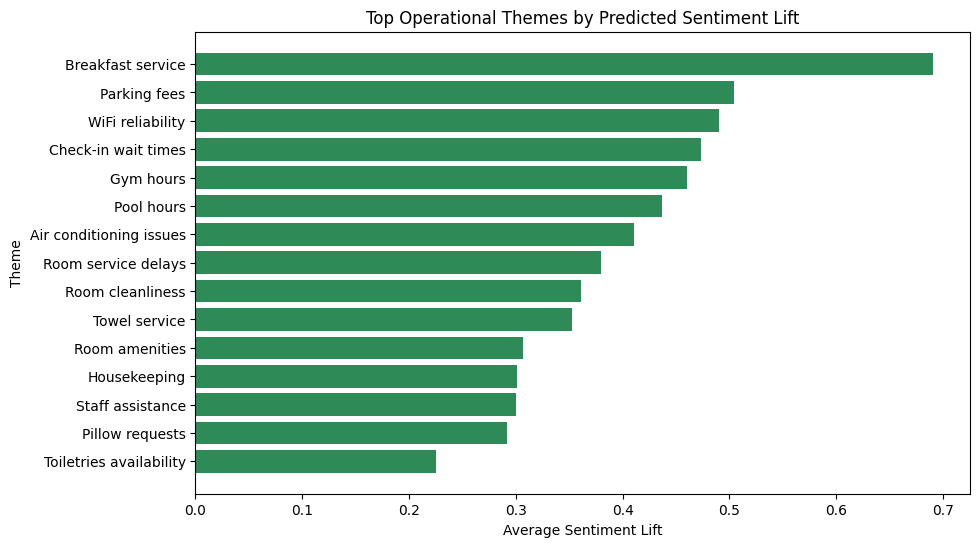

In [16]:

# STEP 10: Visualize top operational themes by predicted sentiment lift


import matplotlib.pyplot as plt

# 1. Create a new figure with specific dimensions (width=10, height=6 inches)
plt.figure(figsize=(10,6))

# 2. Draw a horizontal bar chart
#    - y-axis = theme names
#    - x-axis = avg sentiment lift
#    - color = seagreen (good for positive improvement visuals)
plt.barh(theme_summary["theme"], theme_summary["avg_sentiment_lift"], color="seagreen")

# 3. Label the x-axis
plt.xlabel("Average Sentiment Lift")

# 4. Label the y-axis
plt.ylabel("Theme")

# 5. Add a descriptive title
plt.title("Top Operational Themes by Predicted Sentiment Lift")

# 6. Invert the y-axis so the theme with the highest lift is at the top
plt.gca().invert_yaxis()

# 7. Render the chart
plt.show()


In [17]:

# Add a "priority_score" and pick the Top-N themes to show
# priority_score = complaints_count * avg_sentiment_lift
# This bubbles up high-lift themes that also have meaningful volume.


top_n = 10  # tweak for your slide

# Work on a copy so we don't mutate the original summary
ts = theme_summary.copy()

# 1) Compute priority score
ts["priority_score"] = ts["complaints_count"] * ts["avg_sentiment_lift"]

# 2) Sort by priority score (desc) and take Top-N
ts_top = ts.sort_values("priority_score", ascending=False).head(top_n).reset_index(drop=True)

# 3) Keep for later charts
ts_top


,theme,complaints_count,avg_sentiment_lift,top_suggestion,priority_score
0,Breakfast service,13,0.691,Implement a timed breakfast slot reservation s...,8.983
1,WiFi reliability,15,0.490,Conduct a WiFi site survey to identify dead zo...,7.350
2,Check-in wait times,15,0.473,Implement a mobile check-in option through the...,7.095
3,Parking fees,14,0.504,Implement a tiered parking fee structure based...,7.056
4,Pool hours,14,0.437,Extend pool hours by 2 hours on weekends and h...,6.118
5,Gym hours,10,0.460,Extend gym hours to open at 5 AM instead of 7 ...,4.600
6,Air conditioning issues,9,0.411,Conduct a thorough inspection and maintenance ...,3.699
7,Room cleanliness,9,0.361,Implement a standardized room inspection check...,3.249
8,Housekeeping,8,0.301,Implement a digital checklist system for house...,2.408
9,Room amenities,3,0.307,Implement a digital request system for room am...,0.921


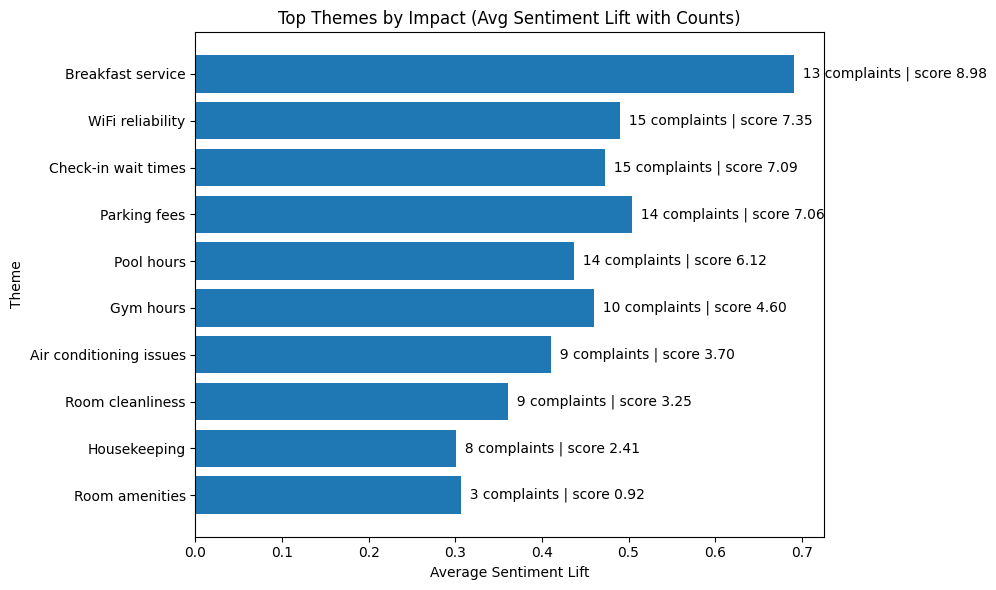

In [18]:

# Horizontal bar chart of Top-N themes by priority_score
# - Bar length = average sentiment lift
# - Annotation = "<complaints_count> complaints | score <priority_score>"


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# 1) Plot avg sentiment lift as horizontal bars
ax.barh(ts_top["theme"], ts_top["avg_sentiment_lift"])

# 2) Invert y so best appears on top
ax.invert_yaxis()

# 3) Titles and labels
ax.set_title("Top Themes by Impact (Avg Sentiment Lift with Counts)")
ax.set_xlabel("Average Sentiment Lift")
ax.set_ylabel("Theme")

# 4) Annotate each bar with complaint count and priority score
for i, (lift, cnt, ps) in enumerate(zip(ts_top["avg_sentiment_lift"], ts_top["complaints_count"], ts_top["priority_score"])):
    # Place text at end of each bar
    ax.text(lift, i, f"  {cnt} complaints | score {ps:.2f}", va="center")

plt.tight_layout()
plt.show()


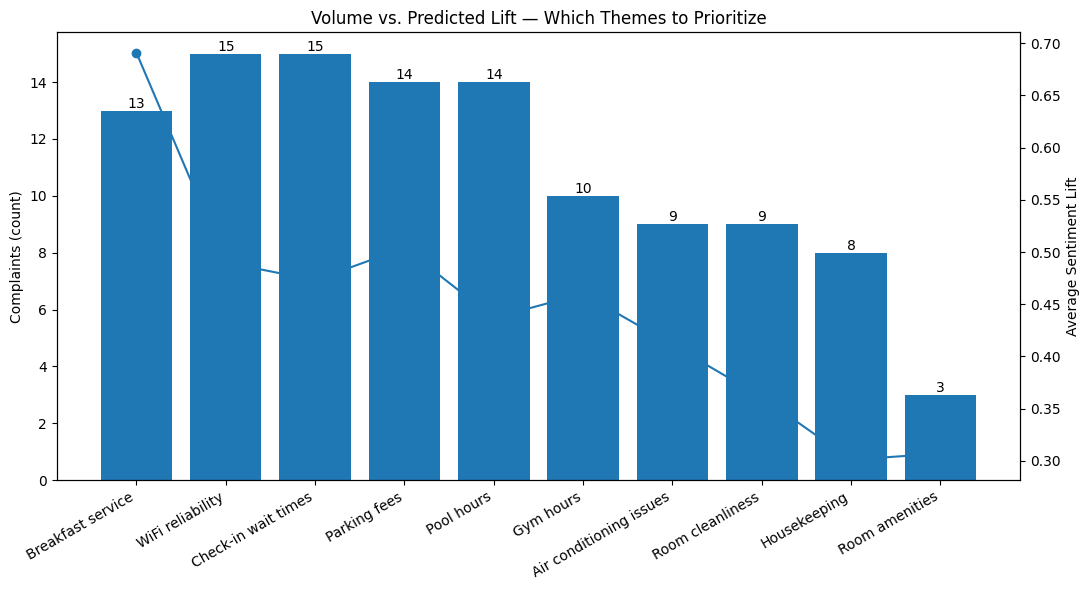

In [19]:

# Dual-axis chart: complaints_count (bars) + avg_sentiment_lift (line)
# - Left y-axis: complaint volume (bars)
# - Right y-axis: average sentiment lift (line with markers)
# This helps spot "quick wins" = high volume + high lift.


import matplotlib.pyplot as plt
import numpy as np

# 1) X positions
x = np.arange(len(ts_top))

# 2) Figure and axes (twinx for second y axis)
fig, ax1 = plt.subplots(figsize=(11, 6))
ax2 = ax1.twinx()

# 3) Bars for complaint counts (left axis)
bars = ax1.bar(x, ts_top["complaints_count"])

# 4) Line for average sentiment lift (right axis)
line = ax2.plot(x, ts_top["avg_sentiment_lift"], marker="o")

# 5) X labels: theme names
ax1.set_xticks(x)
ax1.set_xticklabels(ts_top["theme"], rotation=30, ha="right")

# 6) Axis labels and title
ax1.set_ylabel("Complaints (count)")
ax2.set_ylabel("Average Sentiment Lift")
ax1.set_title("Volume vs. Predicted Lift — Which Themes to Prioritize")

# 7) Add numeric labels on top of bars (counts) for readability
for rect, cnt in zip(bars, ts_top["complaints_count"]):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height, f"{cnt}", ha="center", va="bottom")

# 8) Tidy layout
fig.tight_layout()
plt.show()
